## An introduction to ChEMBL with focus on kinases
This notebook fetches interactions for kinases and does some basic analysis. We can either download them from the web-server or load from a file (previously created). So far, interactions are not filtered and without any values.

## 0. Prerequisites

In [1]:
import numpy as np
import pandas as pd
# from sklearn.metrics import mean_squared_error as rmse
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import TruncatedSVD as tSVD

import  matplotlib.pyplot as plt
random_seed = 2019
np.random.seed(random_seed)

### Load data file from disk
 Create a list with all the associated compounds and give some statistics.

In [2]:
Interactions = []

with open("interactions_kinases_IC50_train.tab", 'r') as file:
    header_line = next(file)
    for line in file:
        tokens = line.split()
        # 'Target-ID', 'Compound-ID', 'Std-value'  
        Interactions.append( [tokens[0], tokens[1], tokens[2] ])

# we use a dataframe to quickly sort targets wrt #compounds:
DF = pd.DataFrame( Interactions, columns =['Target-ID', 'Compound-ID','Std-value']) 
temp = DF.groupby(['Target-ID']).agg('count').sort_values(by='Compound-ID') # count the number of molecules
Targets = list(temp.index)
Compounds = np.unique(DF['Compound-ID'])
del temp, DF

nT=len(Targets); nC=len(Compounds)

print("There are {0} targets and {1} compounds currently loaded with {2} interactions.".format(nT,nC,len(Interactions)))
print("A DTI matrix would be {0:.4}% dense!".format(100.0*len(Interactions)/nT/nC ))

There are 110 targets and 23167 compounds currently loaded with 56392 interactions.
A DTI matrix would be 2.213% dense!


In [3]:
# first we need to prepare each fp as a feature vector
Fingerprints={} # this contains one list per fingerprint - not efficient...
with open('Compound_Fingerprints.tab', 'r') as f:
    header = f.readline()
    for line in f:
        # each line is Comp-ID, SMILES, FP
        tokens = line.split()
        # we keep only those compounds which have FPs
        if tokens[2] != 'NOFP':
            fp = [int(c) for c in tokens[2] ]
            Fingerprints[ tokens[0] ] = fp
print("%d fingerprints were loaded!" % len(Fingerprints))

155083 fingerprints were loaded!


### Split to Train-Validation sets

In [4]:
indices = list(range(len(Interactions)))
split = int(np.floor( 0.2*( len(indices)) ))
# split the active interactions in train-test sets
np.random.shuffle( indices ) # this happens in-place

Interactions_train = [ Interactions[x] for x in indices[split:] ] # the last 80%
Interactions_valid = [ Interactions[x] for x in indices[:split] ] # the first 20%

## 1. Random Forests

In [5]:
RFR_all = dict()
Scores_RFR_train=[]
count=0
param_grid={'n_estimators':[10,25,50,100,150,300], 'max_depth':[3,4,5,7,10,15,25]}
for target in Targets:
    # define the train set
    X_train=[]; Y_train=[]
    for point in Interactions_train:
        if point[0]==target:
            X_train.append( [int(c) for c in Fingerprints[point[1]] ] )
            Y_train.append( float(point[2]) )
    if len(Y_train)>40:
        # we need to ensure there is enough data for CV
        cvr = GridSearchCV(RandomForestRegressor(random_state=2019), param_grid, cv=5, n_jobs=5, iid=True)
        # here comes the long step
        cvr.fit(X_train, Y_train)
        # select best parametrisation and train to the complete train-set
        RFR = RandomForestRegressor( n_estimators= cvr.best_params_['n_estimators'], max_depth=cvr.best_params_['max_depth'], random_state=2019)
        RFR.fit(X_train,Y_train)
        RFR_all[target] = RFR
        Scores_RFR_train.append( RFR.score( X_train,  Y_train))
#         print(Scores_RFR_train[-1])
    else:
        print("Not enough data for %s" % target)
    if count%25==0:print("More than %d targets are processed" % count)
    count+=1
    
print("Mean score for RF during training = %f" % np.mean(Scores_RFR_train) )

More than 0 targets are processed
More than 25 targets are processed
More than 50 targets are processed
More than 75 targets are processed
More than 100 targets are processed
Mean score for RF during training = 0.838784


In [6]:
for model in RFR_all:
    print( RFR_all[model].get_params()['max_depth'])

4
3
10
5
4
3
10
5
10
3
10
15
10
7
10
3
10
15
5
15
10
3
15
4
25
5
7
25
7
10
25
25
25
3
10
7
10
7
25
15
15
10
3
4
25
3
10
3
25
3
25
25
25
4
15
25
3
3
10
5
15
25
25
15
25
25
25
25
3
25
25
15
25
25
25
25
10
25
15
25
25
25
25
25
4
25
25
25
3
25
15
25
15
5
25
25
25
5
3
25
25
25
25
25
25
25
25
25
25
25


## 2. Neural Networks

In [7]:
MLPR_all = dict()
Scores_MLPR_train=[]
param_grid={'hidden_layer_sizes':[(50),(50,100),(50,20,10)] }
count=0
for target in Targets:
    # define the train set
    X_train=[]; Y_train=[]
    for point in Interactions:
        if point[0]==target:
            X_train.append( [int(c) for c in Fingerprints[point[1]] ] )
            Y_train.append( float(point[2]) )
    if len(Y_train)>40:
        # we need to ensure there is enough data for CV
        cvr = GridSearchCV(MLPRegressor(activation='logistic', solver='lbfgs', random_state=2019), param_grid, cv=5, n_jobs=5, iid=True)
        cvr.fit(X_train, Y_train)
        # select best parametrisation and train to the complete train-set
        MLPR = MLPRegressor( hidden_layer_sizes = cvr.best_params_['hidden_layer_sizes'], activation='logistic', solver='lbfgs', random_state=2019)
        MLPR.fit(X_train,Y_train)
        MLPR_all[target] = MLPR
        Scores_MLPR_train.append( MLPR.score( X_train,  Y_train))
#         print(Scores_MLPR_train[-1])
    else:
        print("Not enough data for %s" % target)
    if count%25==0:print("More than %d targets are processed" % count)
    count+=1
    
print("Mean score for NN during training = %f" % np.mean(Scores_MLPR_train))

More than 0 targets are processed
More than 25 targets are processed
More than 50 targets are processed
More than 75 targets are processed
More than 100 targets are processed
Mean score for NN during training = 0.684588


## 3. Lasso Regression

In [8]:
from sklearn.linear_model import Lasso

LR_all = dict()
Scores_LR_train=[]
count=0
for target in Targets:
    # define the train set
    X_train=[]; Y_train=[]
    for point in Interactions:
        if point[0]==target:
            X_train.append( [int(c) for c in Fingerprints[point[1]] ] )
            Y_train.append( float(point[2]) )
    # cross validation
    param_grid={'alpha':[1, 0.5, 0.1, 0.01]}
    cvr = GridSearchCV(Lasso(random_state=2019, max_iter=5000), param_grid, cv=5, n_jobs=3, iid=True)
    cvr.fit(X_train, Y_train)
    # select best parametrisation
    LR = Lasso( alpha= cvr.best_params_['alpha'], max_iter=5000, random_state=2019)
    LR.fit(X_train,Y_train)
    Scores_LR_train.append( LR.score( X_train,  Y_train))
    LR_all[target] = LR
#     print(Scores_LR_train[-1])
    if count%25==0:print("More than %d targets are processed" % count)
    count+=1 

print("Mean score for LR during training = %f" % np.mean(Scores_LR_train) )

More than 0 targets are processed


/homes/kalantzi/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 585703.7465964807, tolerance: 22752.095962891184
  positive)
/homes/kalantzi/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 585703.7465964807, tolerance: 22752.095962891184
  positive)
/homes/kalantzi/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3824722.0595887452, tolerance: 12113.953129993115
  positive)
/homes/kalantzi/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

More than 25 targets are processed


/homes/kalantzi/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42406.9787555048, tolerance: 19734.43476246552
  positive)
/homes/kalantzi/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42406.9787555048, tolerance: 19734.43476246552
  positive)
/homes/kalantzi/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2103651.356200206, tolerance: 50489.38488204968
  positive)
/homes/kalantzi/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

More than 50 targets are processed


/homes/kalantzi/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10960007.81402142, tolerance: 170363.76161767487
  positive)
/homes/kalantzi/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10960007.81402142, tolerance: 170363.76161767487
  positive)
/homes/kalantzi/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3183279.759634439, tolerance: 84666.02697017886
  positive)
/homes/kalantzi/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the n

More than 75 targets are processed
More than 100 targets are processed
Mean score for LR during training = 0.924854


In [9]:
for model in RFR_all:
    print( LR_all[model].get_params()['alpha'])

1
1
0.1
0.01
1
0.01
0.01
0.01
0.01
1
1
0.01
1
1
0.01
0.01
1
1
0.1
0.01
1
1
1
1
1
0.1
1
0.01
0.01
1
1
1
1
1
1
0.01
0.01
1
1
1
1
1
1
1
1
1
0.01
1
1
1
1
1
0.01
1
1
1
0.01
1
1
1
0.1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


## 4. Evaluation

In [10]:
Pred_MLPR = []
Pred_RFR  = []
Pred_LR = []
True_vals = []
Pred_pertarget = dict() # contains lists with tuples: (true, pred_RF, pred_NN)

with open("first_cv_results.txt",'w') as f:
    f.write("Target\tTrue\tRFR\tMLPR\tLR\n")
    for point in Interactions_valid:
        True_vals.append( float(point[2]) )
        x_test = np.array( Fingerprints[point[1]] )

        model = RFR_all[point[0]]
        Pred_RFR.append( model.predict( x_test.reshape(1,-1) ) )

        model = MLPR_all[point[0]]
        Pred_MLPR.append( model.predict( x_test.reshape(1,-1) ))
        
        model = LR_all[point[0]]
        Pred_LR.append( model.predict( x_test.reshape(1,-1) ))
        
        f.write("{0}\t{1}\t{2}\t{3}\t{4}\n".format(point[0], True_vals[-1], Pred_RFR[-1][0], Pred_MLPR[-1][0], Pred_LR[-1][0]))

        if point[0] in Pred_pertarget:
            Pred_pertarget[point[0]].append( (True_vals[-1], Pred_RFR[-1][0], Pred_MLPR[-1][0], Pred_LR[-1][0])  )
        else:
            # first time for this protein
            Pred_pertarget[point[0]] = [ (True_vals[-1], Pred_RFR[-1][0], Pred_MLPR[-1][0], Pred_LR[-1][0]) ]
            
print("Performance for LR = %f" % r2_score(True_vals, Pred_LR))
print("Performance for RF = %f" % r2_score(True_vals, Pred_RFR))
print("Performance for NN = %f" % r2_score(True_vals, Pred_MLPR))

Performance for LR = 0.860530
Performance for RF = 0.356750
Performance for NN = 0.651037


In [27]:
for i in range(50):
    print(True_vals[i],'\t', Pred_MLPR[i])
print(     MSE( True_vals, Pred_MLPR ))
print(r2_score( True_vals, Pred_MLPR ))
print(     MAE( True_vals, Pred_MLPR ))

1000.0 	 [254.08279739]
300.0 	 [480.41402686]
584.0 	 [2360.12799629]
10.0 	 [53.65552243]
35.0 	 [284.7825279]
3.0 	 [168.64831657]
20.0 	 [4164.60938578]
9.0 	 [60.04096456]
3000.0 	 [3498.45314235]
39.0 	 [420.01060192]
15.0 	 [237.40649833]
10.0 	 [115.33077626]
1000.0 	 [1139.93880038]
120.0 	 [703.15528837]
60.0 	 [277.3711605]
3131.0 	 [859.6618952]
230.0 	 [253.15218943]
235.0 	 [184.1411234]
1000.0 	 [310.20857895]
4500.0 	 [5808.09201417]
1280.0 	 [103.83361442]
271.6 	 [184.14236836]
1000.0 	 [198.91278456]
72.0 	 [184.1411234]
2422.0 	 [1959.25003206]
0.5 	 [116.25610237]
360.0 	 [253.15218943]
1000.0 	 [321.03803717]
61.0 	 [269.21484382]
6025.6 	 [5182.96855281]
710.0 	 [1610.47207924]
1000.0 	 [857.42711786]
51.5 	 [15.6595935]
25.2 	 [202.17149108]
67.61 	 [123.8103675]
66.0 	 [409.78405553]
8.0 	 [159.40934651]
14.0 	 [384.88396304]
4500.0 	 [4546.47305276]
97.0 	 [126.370325]
2700.0 	 [3369.40219541]
610.0 	 [851.4433682]
77.0 	 [115.33076775]
5000.0 	 [129.35411806]

In [12]:
Scores_LR_valid_pertarget  = []
Scores_RFR_valid_pertarget = []
Scores_MLPR_valid_pertarget= []

for target in Pred_pertarget:
    true=[]
    pred_RF=[]; pred_NN=[]; pred_LR=[]
    # aggregate predictions
    for triplet in Pred_pertarget[target]:
        true.append( triplet[0] )
        pred_RF.append( triplet[1] )
        pred_NN.append( triplet[2] )
        pred_LR.append( triplet[3] )
    # calculate performance
    Scores_LR_valid_pertarget.append(  r2_score(true, pred_LR) )
    Scores_RFR_valid_pertarget.append( r2_score(true, pred_RF) )
    Scores_MLPR_valid_pertarget.append(r2_score(true, pred_NN) )

    print("R2 score for {0}, LR | RF | NN = {1} | {2} | {3}".format(target, Scores_LR_valid_pertarget[-1], Scores_RFR_valid_pertarget[-1], Scores_MLPR_valid_pertarget[-1]))
    
print("Mean per target R2-score for LR = %f " % np.mean(Scores_LR_valid_pertarget))
print("Mean per target R2-score for RF = %f " % np.mean(Scores_RFR_valid_pertarget))
print("Mean per target R2-score for NN = %f " % np.mean(Scores_MLPR_valid_pertarget))

R2 score for CHEMBL260, LR | RF | NN = 0.9145889017088404 | 0.3871918328453612 | 0.6074261942709349
R2 score for CHEMBL4722, LR | RF | NN = 0.8185819247198214 | 0.2921962104062844 | 0.8321281705026897
R2 score for CHEMBL2695, LR | RF | NN = 0.9073987152341256 | 0.34736071188915096 | 0.39667921421721586
R2 score for CHEMBL3038477, LR | RF | NN = 0.8879191229573999 | 0.7540767692035429 | 0.9582303597985636
R2 score for CHEMBL2996, LR | RF | NN = 0.8132025380926408 | 0.19372187968810128 | 0.5124155892899422
R2 score for CHEMBL2148, LR | RF | NN = 0.8264847762656582 | 0.4897159899871565 | 0.4755554318325277
R2 score for CHEMBL2147, LR | RF | NN = 0.7498578063809017 | 0.2327003411197388 | 0.6394165406647883
R2 score for CHEMBL5147, LR | RF | NN = 0.9083482810910783 | 0.4321571850117596 | 0.6702569637929174
R2 score for CHEMBL308, LR | RF | NN = 0.9380124094699418 | 0.44933535795541635 | 0.7535177272785836
R2 score for CHEMBL3234, LR | RF | NN = 0.9868185367801643 | -0.008646749916507934 | 0

In [13]:
from sklearn.metrics import mean_squared_log_error as MSLE
print("MSE for LR = %f" % np.sqrt( MSE(True_vals, Pred_LR)) )
print("MSE for RF = %f" % np.sqrt( MSE(True_vals, Pred_RFR)) )
print("MSE for NN = %f" % np.sqrt( MSE(True_vals, Pred_MLPR)))

MSE for LR = 646.227929
MSE for RF = 1387.828713
MSE for NN = 1022.199508


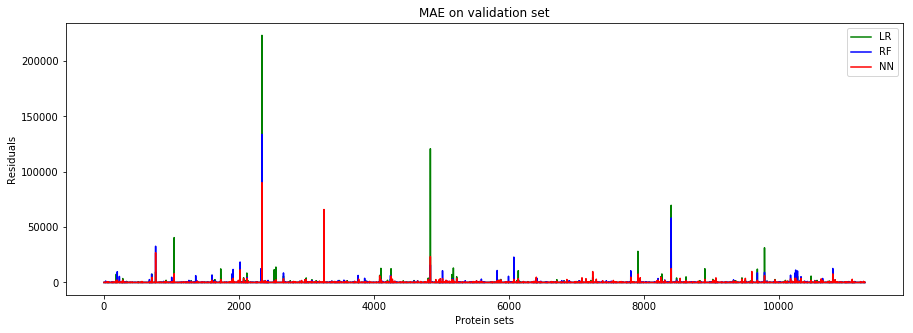

In [14]:
Scores_LR_valid = []
Scores_RFR_valid = []
Scores_MLPR_valid= []
for i in range(len(Interactions_valid)):
    Scores_LR_valid.append( np.abs( float(Interactions_valid[i][2]) - Pred_LR[i][0])/float(Interactions_valid[i][2]) )
    Scores_RFR_valid.append( np.abs( float(Interactions_valid[i][2]) - Pred_RFR[i][0])/float(Interactions_valid[i][2]) )
    Scores_MLPR_valid.append( np.abs( float(Interactions_valid[i][2]) - Pred_MLPR[i][0])/float(Interactions_valid[i][2]) )

plt.figure(figsize=(15,5))
plt.plot(Scores_LR_valid,'g', label='LR')
plt.plot(Scores_RFR_valid,'b', label='RF')
plt.plot(Scores_MLPR_valid,'r', label='NN')
plt.legend(loc=1)
plt.xlabel('Protein sets')
plt.ylabel('Residuals')
plt.title("MAE on validation set")
plt.show()

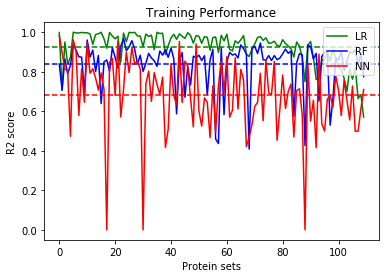

In [15]:
plt.figure()
plt.plot(Scores_LR_train,'g', label='LR')
plt.axhline(np.mean(Scores_LR_train),color='g', linestyle='--')
plt.plot(Scores_RFR_train,'b', label='RF')
plt.axhline(np.mean(Scores_RFR_train),color='b', linestyle='--')
plt.plot(Scores_MLPR_train,'r', label='NN')
plt.axhline(np.mean(Scores_MLPR_train),color='r', linestyle='--')
plt.legend(loc=1)
plt.xlabel('Protein sets')
plt.ylabel('R2 score')
plt.title("Training Performance")
plt.savefig("Train-all.png")
plt.show()

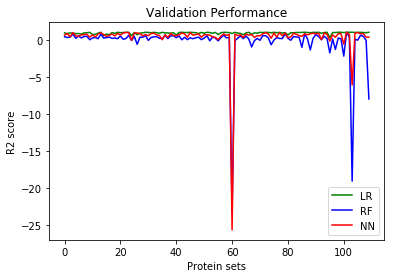

In [18]:
plt.figure()
plt.plot(Scores_LR_valid_pertarget,'g', label='LR')
plt.plot(Scores_RFR_valid_pertarget,'b', label='RF')
plt.plot(Scores_MLPR_valid_pertarget,'r', label='NN')
plt.legend(loc=4)
plt.xlabel('Protein sets')
plt.ylabel('R2 score')
plt.title("Validation Performance")
plt.savefig("Valid-LR.RF.NN.png")
plt.show()

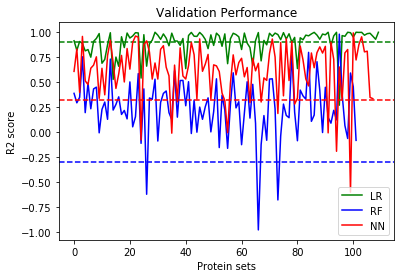

In [25]:
plt.figure()
plt.plot([x for x in Scores_LR_valid_pertarget if x> -1],'g', label='LR')
plt.axhline(np.mean(Scores_LR_valid_pertarget),color='g', linestyle='--')

plt.plot([x for x in Scores_RFR_valid_pertarget if x> -1],'b', label='RF')
plt.axhline(np.mean(Scores_RFR_valid_pertarget),color='b', linestyle='--')

plt.plot([x for x in Scores_MLPR_valid_pertarget if x> -1],'r', label='NN')
plt.axhline(np.mean(Scores_MLPR_valid_pertarget),color='r', linestyle='--')

plt.legend(loc=4)
plt.xlabel('Protein sets')
plt.ylabel('R2 score')
plt.title("Validation Performance")
plt.savefig("Valid-filtered.png")
plt.show()

In [24]:
from sklearn.metrics import mean_absolute_error as MAE
MAE(True_vals, Pred_MLPR)

521.8833497865968